### Step 4: Feature Diversity and Market Segmentation  
**Objective**: Understand the relationship between feature diversity and market segments to uncover trends in flagship, midrange, and budget phones.  

---

### **Key Tasks**

#### **1. Average Feature Count Across Segments**
- **Method**:  
  Group phones by market segment (`flagship`, `midrange`, `budget`) and calculate the average number of features (`has_5g`, `has_nfc`, etc.).  
- **Insight**:  
  Determine whether flagship phones consistently offer significantly more features than budget or midrange models.  

---

#### **2. Price-to-Feature Ratio**
- **Method**:  
  Calculate and compare the price-to-feature ratio (price divided by feature count) across segments.  
- **Insight**:  
  Highlight which segment offers the best value for consumers.  

---


#### **3. Low Adoption Features**
- **Method**:  
  Calculate the adoption rate of each feature (`has_ir_blaster`, `fast_charging_available`, etc.) across all phones and segments.  
  - **Threshold**: Identify features with adoption rates below 20%.  
- **Insight**:  
  Highlight features with minimal uptake that could be targeted for improvement or phased out.  


# Import Libraries

In [1]:
import os

import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.preprocessing import PowerTransformer

from src.utils.utils import (
    get_data,
    outlier_overview, 
    export_data, 
    prepare_segment_trends_data, 
    numerical_categorical_analysis,
    anova_test,
    test_for_normality,
    mann_whitney_test,
    numerical_analysis,
    two_sample_independent_ttest,
    levene_test,
    categorical_analysis
    
)

from scipy.stats import probplot, pearsonr

from src.constants.constants import FIG_SIZE

In [2]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) 

# Read the Data

In [3]:
df = get_data("smartphone_cleaned_v5", "processed")
analysis_df = prepare_segment_trends_data(df)
analysis_df.head()

,brand_name,model,price,rating,has_5g,has_nfc,has_ir_blaster,processor_brand,num_cores,processor_speed,battery_capacity,fast_charging_available,fast_charging,ram_capacity,internal_memory,screen_size,refresh_rate,resolution,num_rear_cameras,num_front_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,extended_upto
0,oneplus,OnePlus 11 5G,54999,89.0,True,True,False,snapdragon,8.0,3.2,5000.0,1,100.0,12.0,256.0,6.70,120,1440 x 3216,3,1.0,android,50.0,16.0,0,0.0
1,oneplus,OnePlus Nord CE 2 Lite 5G,19989,81.0,True,False,False,snapdragon,8.0,2.2,5000.0,1,33.0,6.0,128.0,6.59,120,1080 x 2412,3,1.0,android,64.0,16.0,1,1024.0
2,samsung,Samsung Galaxy A14 5G,16499,75.0,True,False,False,exynos,8.0,2.4,5000.0,1,15.0,4.0,64.0,6.60,90,1080 x 2408,3,1.0,android,50.0,13.0,1,1024.0
3,motorola,Motorola Moto G62 5G,14999,81.0,True,False,False,snapdragon,8.0,2.2,5000.0,1,NaN,6.0,128.0,6.55,120,1080 x 2400,3,1.0,android,50.0,16.0,1,1024.0
4,realme,Realme 10 Pro Plus,24999,82.0,True,False,False,dimensity,8.0,2.6,5000.0,1,67.0,6.0,128.0,6.70,120,1080 x 2412,3,1.0,android,108.0,16.0,0,0.0


In [4]:
budget = (
    analysis_df
    .loc[lambda x: x['price'] <= 23000]
)

In [5]:
mid = (
    analysis_df
    .loc[lambda x: (x['price'] > 23000) & (x['price'] <= 50000)]
)

In [6]:
premium = (
    analysis_df
    .loc[lambda x: x['price'] > 50000]
)

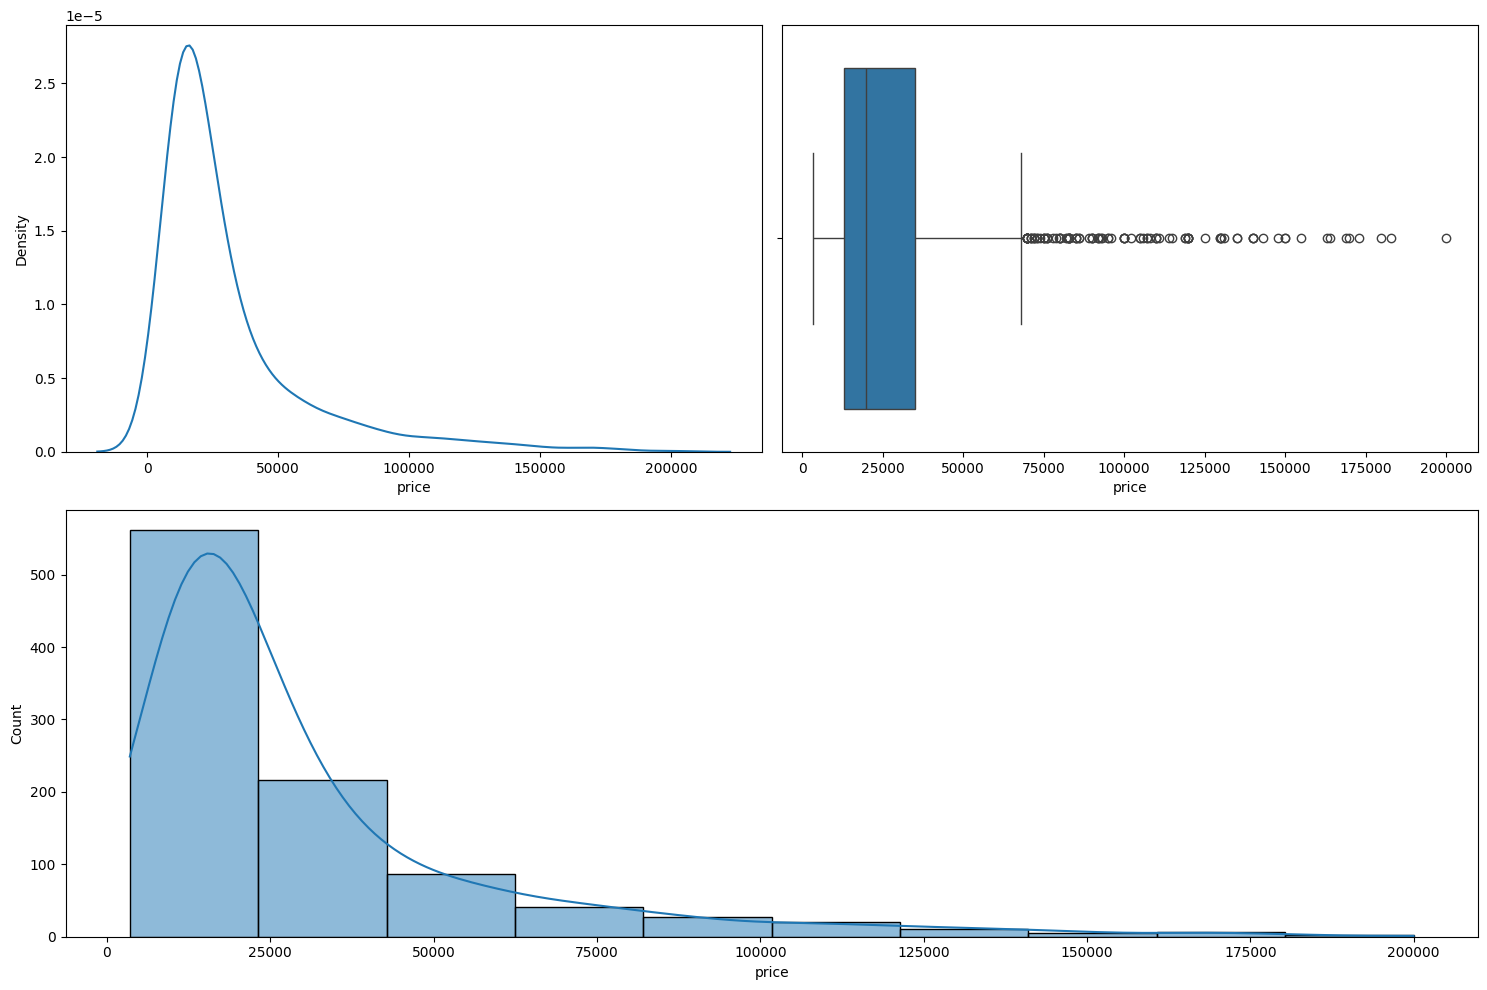

In [7]:
numerical_analysis(analysis_df, "price", bins = 10)

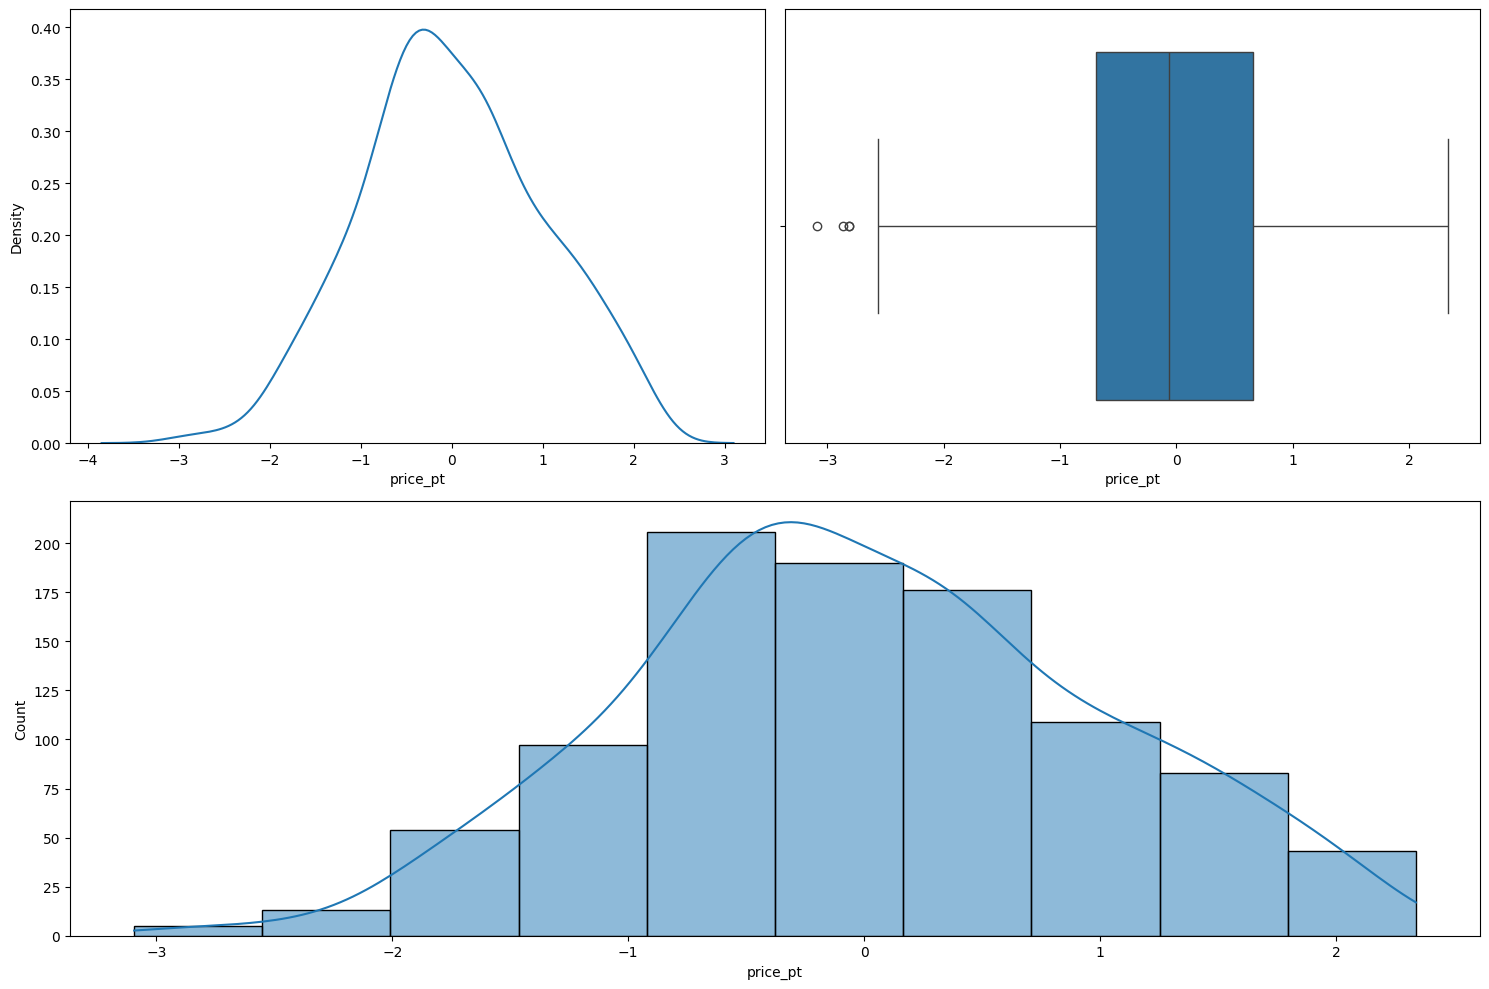

In [8]:
pt = PowerTransformer(method = "yeo-johnson")

analysis_df = analysis_df.assign(price_pt = lambda df: pt.fit_transform(analysis_df[["price"]]))

numerical_analysis(analysis_df, "price_pt", bins=10)

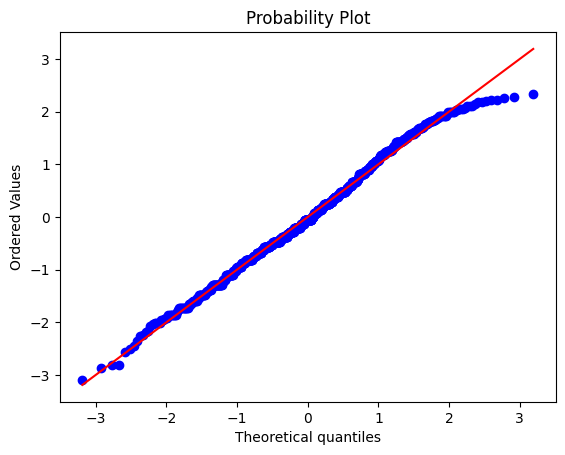

In [9]:
# plot QQ plot for the price

probplot(analysis_df["price_pt"], plot = plt)
plt.show()

In [10]:
test_for_normality(dataframe = analysis_df, column_name = "price_pt")

Jarque Bera Test for Normality
0.07228337941564213
Fail to reject the null hypothesis. The data is normally distributed.


## Observations

- Price column is positively skewed.
- Price column is normally distributed after applying yeo-johnson power transformer.

# Average Feature Count Across Segments

In [18]:
feature_columns = [
    'has_5g', 'has_nfc', 'has_ir_blaster', 
    'fast_charging_available', 'extended_memory_available'
]


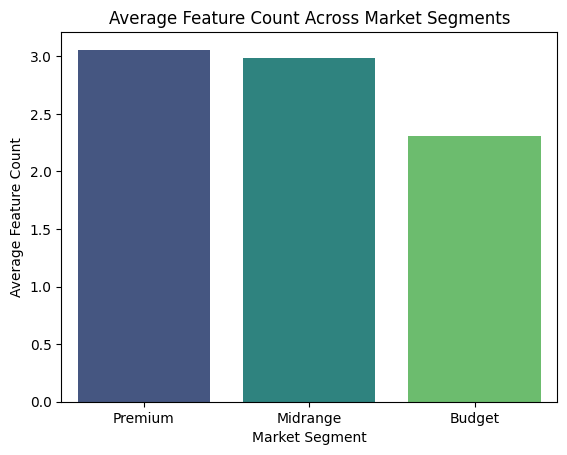

In [24]:
sns.barplot(
    x=['Premium', 'Midrange', 'Budget'],
    y=[
        premium[feature_columns].sum(axis=1).mean(),
        mid[feature_columns].sum(axis=1).mean(),
        budget[feature_columns].sum(axis=1).mean()
    ],
    hue=['Premium', 'Midrange', 'Budget'],
    palette='viridis',
    legend=False
)
plt.title('Average Feature Count Across Market Segments')
plt.xlabel('Market Segment')
plt.ylabel('Average Feature Count')
plt.show()


# Price-to-Feature Ratio

In [43]:
def calculate_price_to_feature(df: pd.DataFrame, feature_columns: list[str]) -> pd.DataFrame:
    """
    Calculate the price-to-feature ratio for each row in the given DataFrame.

    The function computes the ratio of the 'price' column to the sum of specified 
    feature columns for each row. If the sum of the feature columns is zero, it is replaced with NaN 
    to avoid division by zero.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the 'price' and feature columns.
    feature_columns (list[str]): List of column names to be used in the sum for the feature columns.

    Returns:
    pd.DataFrame: A DataFrame with an additional column 'price_to_feature', representing the calculated ratio.
    """
    feature_sum = df[feature_columns].sum(axis=1)
    feature_sum[feature_sum == 0] = np.nan 
    return df.assign(
        price_to_feature=(df['price'] / feature_sum)
    )

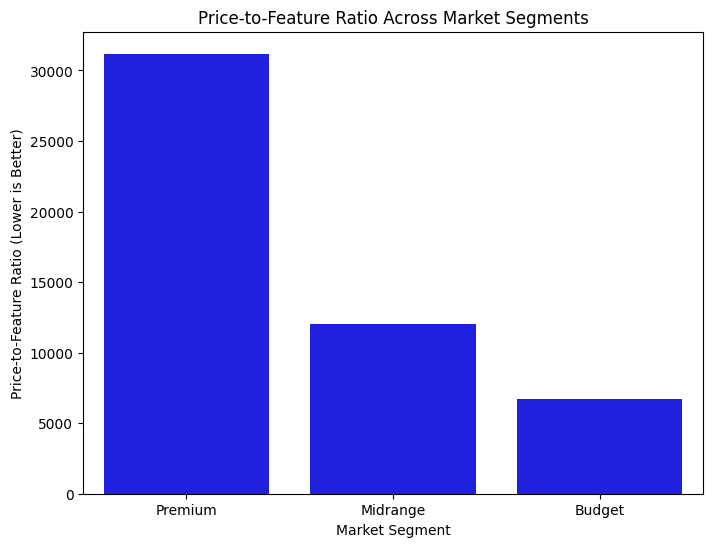

In [34]:
# List of segments and corresponding DataFrames
segments = ['Premium', 'Midrange', 'Budget']
dfs = [premium, mid, budget]

results = {
    segment: df.pipe(calculate_price_to_feature, feature_columns).price_to_feature.mean()
    for segment, df in zip(segments, dfs)
}


price_to_feature_avg = pd.DataFrame({
    'Segment': list(results.keys()),
    'Price_to_Feature_Ratio': list(results.values())
})


plt.figure(figsize=(8, 6))
sns.barplot(data=price_to_feature_avg, x='Segment', y='Price_to_Feature_Ratio', color='blue')  # Replace palette with color
plt.title('Price-to-Feature Ratio Across Market Segments')
plt.xlabel('Market Segment')
plt.ylabel('Price-to-Feature Ratio (Lower is Better)')
plt.show()

In [44]:
price_to_feature_avg

,Segment,Price_to_Feature_Ratio
0,Premium,31185.059615
1,Midrange,12039.821899
2,Budget,6713.162034


# Low Adoption Features

In [41]:
# Display low adoption features
print("Low Adoption Features (below 20% adoption rate):")

(
    df[feature_columns]  
    .pipe(lambda x: x.mean())  
    .pipe(lambda x: x[x < 0.2])  
    .reset_index()  
    .rename(columns={0: 'Adoption Rate'}) 
    .assign(Feature=lambda x: x['index']) 
    .drop(columns=['index']) 
)


Low Adoption Features (below 20% adoption rate):


,Adoption Rate,Feature
0,0.13369,has_nfc
1,0.16221,has_ir_blaster


## Observations

- Premium segment has highest average feature count(3.1), followed by mid range(3) then budget(2.3).
- Price to feature ratio is very high for premium (31185), midrange(12039) and budget(6713).
- Low Adoption Features - NFC and Ir blaster.